<h1> Wasserstein GAN

https://arxiv.org/pdf/1701.07875.pdf

Wasserstein GAN
Vorteile:
    - bessere Traings-Stabilität als DCGAN
Nachteile:
    - Längeres training

Idee beim GAN:
    - Distanz zwischen prob generate und prob realistic soll so klein
    wie möglich sein, um möglichst realistische Bilder zu generieren

Problem:
    - Wie wird die Distanz zwischen den beiden prob Distributionen
    beschrieben/ definiert

Lösung:
    - Wasserstein Distance -> WGAN nutzt Wasserstein Distance für den Loss
    (- Kullback-Leiber (KL) divergence)
    (- Jensen-Shannon (JS) divergence) <- Equivalent zum GAN Loss
        -> Hat Gradienten Probleme die das Training instabil werden lassen

WGAN:
    - Disc. Maximierung von Expression
    - Gen.  Minimierung von Expression

Default- Werte im WGAN
    - LR = 0.00005
    - Clipping Parameter = 0.01
    - Batch Size = 64
    - n_critic = 5 (Anzahl der Iterationen von critic pro generation iteration)

<h2> Download "Opendatasets" und "Torchsummary"

In [ ]:
#Opendataset installieren
!pip install opendatasets #ist eine Python-Bibliothek zum Herunterladen von Datensätzen aus Online-Quellen wie Kaggle und Google Drive.
!pip install torchsummary

<h2> Importieren der Pakete

In [2]:
import torch.nn.functional as F  # Loss
from torchvision.utils import save_image  # Speichern von Bildern
import torch.optim as optim  # Optimierungs-Algorithmen
import torch.nn as nn  # Neuronales Netz
from torchvision.utils import make_grid
import matplotlib.pyplot as plt  # plotten von Grafen/ Bildern
import torchvision.transforms as transforms  # Transformieren von Bildern
import torchvision.datasets as ImageFolder
import torch.utils.data as DataLoader
from torchvision import datasets
import torchvision
import torch as t
import numpy as np
import os                 # Dient zum lokalen Speichern des Datasets
import opendatasets as od
from random import weibullvariate
from torchsummary import summary

<h2> Definieren von Parametern

In [3]:
IMAGE_SIZE = 64  # Größe der Bilder
BATCH_SIZE = 64  # Anzahl der Batches
WORKERS = 2  # Anzahl der Kerne beim Arbeiten auf der GPU
# Normalisierung mit 0.5 Mittelwert und Standardabweichung für alle drei Channels der Bilder
NORM = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
NUM_EPOCH = 20  # Anzahl der Epochen
LR = 0.00005  # Learningrate
LATENT_SIZE = 100  # Radom Input für den Generator
N_CRTIC = 5
WEIGHT_CLIPPING = 0.01

<h2> Download des Datasets von Kaggle 

In [4]:
# https://jovian.ai/ahmadyahya11/pytorch-gans-anime
# Ordner für den Download anlegen
data_dir = '../data/'
os.makedirs(data_dir, exist_ok=True)  # Anlegen eines Ordners für Bilder

In [5]:
# Erklärung zum Umgang mit Opendata und Kaggle - https://pypi.org/project/opendatasets/
# Datensatz:Anime-Faces werden von Kaggle geladen
# Hierfür wird der User-API-KEY benötigt
# APIKEY {"username":"kimmhl","key":"f585163b4ee30f0a5b44b1a902dc56e6"}
dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
# Images werden in './animefacedataset' gespeichert
od.download(dataset_url, data_dir)

Skipping, found downloaded files in "../data/animefacedataset" (use force=True to force download)


In [6]:
"""
Ausgabe zu der Ordner in "../data/"
"""
print(os.listdir(data_dir))  # zeigt Ordner an

['animefacedataset', '.gitkeep', 'outputs']


In [7]:
# gibt 10 Bezeichnungen von Bildern aus
print(os.listdir(data_dir+'animefacedataset/images')[:10])

['4426_2003.jpg', '38921_2012.jpg', '55591_2016.jpg', '8777_2004.jpg', '56274_2017.jpg', '24208_2008.jpg', '13759_2006.jpg', '19302_2007.jpg', '14698_2006.jpg', '30569_2010.jpg']


<h2> Vorbereiten& Erstellen des Dataloaders

In [8]:
# Transformer
transform = transforms.Compose([
    # Resize der Images auf 64 der kürzesten Seite; Andere Seite wird
    transforms.Resize(IMAGE_SIZE),
    # skaliert, um das Seitenverhältnis des Bildes beizubehalten.
    # Zuschneiden auf die Mitte des Images, sodass ein quadratisches Bild mit 64 x 64 Pixeln entsteht
    transforms.CenterCrop(IMAGE_SIZE),
    # Umwandeln in einen Tensor (Bildern in numerische Werte umwandeln)
    transforms.ToTensor(),
    transforms.Normalize(*NORM)])          # Normalisierung Mean & Standardabweichung von 0.5 für alle Channels
# (Anzahl: 3 für farbige Bilder)
# Pixelwerte liegen damit zwischen (-1;1)

In [9]:
# Dataset
"""
ImageFolder() : Befehl erwartet, dass nach Images nach labeln organisiert sind (root/label/picture.png)
"""
org_dataset = torchvision.datasets.ImageFolder(
    root=data_dir, transform=transform)

In [10]:
# Dataloader
"""
Dataloader(): ermöglicht zufällige Stichproben der Daten auszugeben;
Dient dazu, dass das Modell nicht mit dem gesamten Dataset umgehen muss > Training effizienter
"""
org_loader = t.utils.data.DataLoader(org_dataset,              # Dataset (Images)
                                     # Es wird auf Batches trainiert, damit auf Basis eines Batch-Fehlers das NN angepasst wird
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=WORKERS)

<h2> Abfrage des Devices (CPU o. GPU) und Laden des Tensors auf das jeweilige verfügbare Device

In [11]:
#Nutzen der GPU wenn vorhanden, ansonsten CPU
def get_default_device():
    if t.cuda.is_available():     # Wenn cuda verfügbar dann:
        return t.device('cuda')   # Nutze Device = Cuda (=GPU)
    else:                         # Ansonsten
        return t.device('cpu')    # Nutze Device = CPU

In [12]:
# Anzeigen welches Device verfügbar ist
device = get_default_device()
print(device)

cpu


*Hilfsklasse zum Verschieben des Dataloaders "org_loader" auf das jeweilige Device*

In [13]:
class DeviceDataLoader():

    # Initialisierung
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    # Anzahl der Images pro Batch
    def __len__(self):
        return len(self.dataloader)

    # Erstellt einen Batch an Tensoren nach dem Verschieben auf das Device
    def __iter__(self):
        for batch in self.dataloader:
            yield tuple(tensor.to(self.device) for tensor in batch)

In [14]:
# Dataloader auf dem verfügbaren Device
org_loader = DeviceDataLoader(org_loader, device)

<h2> Generator

In [15]:
class Generator(t.nn.Module):
    """
    Generator 1 Input Layer; 3 Hidden Layer ; 1 Output Layer
    """

    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            # Output = (inputsize - 1)*stride - 2*padding + (kernelsite-1)+1
            # ConvTranspose2d hilft dabei aus einem kleinen
            nn.ConvTranspose2d(LATENT_SIZE, IMAGE_SIZE*8, 4, 1, 0, bias=False),
            # Tensor einen größeren Tensor zu erstellen (Bezogen auf Channels)
            nn.BatchNorm2d(IMAGE_SIZE*8),
            nn.ReLU(inplace=True),  # Relu lässt keine negativen werte zu

            nn.ConvTranspose2d(IMAGE_SIZE*8, IMAGE_SIZE * \
                               4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(IMAGE_SIZE*4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(IMAGE_SIZE*4, IMAGE_SIZE * \
                               2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(IMAGE_SIZE*2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(IMAGE_SIZE*2, IMAGE_SIZE, 4, 2, 1, bias=False),
            nn.BatchNorm2d(IMAGE_SIZE),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(IMAGE_SIZE, 3, 4, 2, 1, bias=False),
            nn.Tanh()  # (-1 und 1) ; Tanh wird häufig verwendet da eine begrenzte Aktivierung es dem Modell ermöglicht,
            # schneller zu lernen. (https://arxiv.org/pdf/1511.06434.pdf S. 3)

            # Output: 3 x 64 x 64
        )

    # Feedforward
    def forward(self, input):
        output = self.generator(input)
        return output

In [16]:
# Erstellen des Generators
NN_Generator = Generator().to(device)
print(NN_Generator)

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
 

<h2> Critic/ Diskriminator

In [17]:
class Discriminator (t.nn.Module):
    """
    Diskriminator 1 Input Layer; 3 Hidden Layer ; 1 Output Layer
    """

    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            # Output = ((inputsize) + 2*padding + (kernelsite-1)-1/stride) -1
            # conv2d hilft dabei aus einem großem Tensor einen kleinen Tensor zu stellen
            nn.Conv2d(3, IMAGE_SIZE, 4, 2, 1, bias=False),
            # Leaky RELU lässt negative Werte zu (nicht wie RELU); Neuronen werden somit nicht auf Null gesetzt
            nn.LeakyReLU(0.2, inplace=True),
            # Hilft dem Generator, da dieser nur "Lernen" kann wenn er vom Diskriminator einen Gradienten erhält

            # state size. (IMAGE_SIZE) x 32 x 32
            nn.Conv2d(IMAGE_SIZE, IMAGE_SIZE * 2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(IMAGE_SIZE * 2, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (IMAGE_SIZE*2) x 16 x 16
            nn.Conv2d(IMAGE_SIZE * 2, IMAGE_SIZE * 4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(IMAGE_SIZE * 4, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(0.1),  #Dropout

            # state size. (IMAGE_SIZE*4) x 8 x 8
            nn.Conv2d(IMAGE_SIZE * 4, IMAGE_SIZE * 8, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(IMAGE_SIZE * 8, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.1),

            # state size. (IMAGE_SIZE*8) x 4 x 4
            nn.Conv2d(IMAGE_SIZE * 8, 1, 4, 1, 0, bias=False))

        # Sigmoid Aktivierungsfunktion
        # nn.Sigmoid())  # (Werte zwischen 0 und 1); Sigmoid wird verwendet, um zu erkenen wie weit die generierten Bilder von den orginalen abweichen

    def forward(self, input):
        output = self.discriminator(input)
        output = output.view(output.size(0), -1)
        return output

In [18]:
# Erstellen des Diskriminators
NN_Discriminator = Discriminator().to(device)
print(NN_Discriminator)

Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Dropout2d(p=0.1, inplace=False)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=

*Hilfsfunktionen zur Normalisierng von Tensoren und grafischen Darstellung*

In [19]:
def tensor_norm(img_tensors):
    return img_tensors * NORM[1][0] + NORM[0][0]

In [20]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title("Fake_Images")
    ax.imshow(make_grid(tensor_norm(images.detach()[:nmax]), nrow=8).permute(
        1, 2, 0).cpu())     # detach() : erstellt eine neue "Ansicht",
                            # sodass diese Operationen nicht mehr verfolgt werden,
                            # d. h. der Gradient wird nicht berechnet und der Untergraph
                            # wird nicht aufgezeichnet > Speicher wird nicht verwendet

Radom Tensor

In [21]:
# Generator --> Input: Random Tensor
# Generator --> Output: Fake-Images (Batchsize, data_dim, Pixel, Pixel)
random_Tensor = t.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
fake_images = NN_Generator(random_Tensor)
print(fake_images.shape)

torch.Size([64, 3, 64, 64])


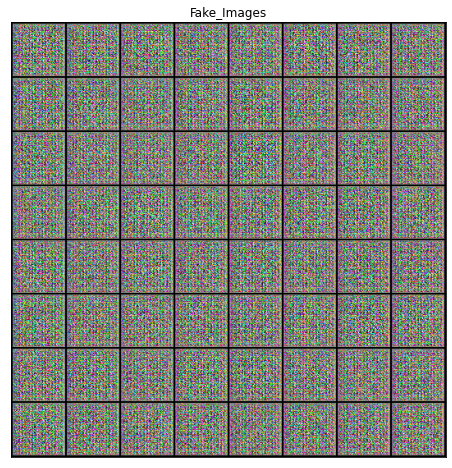

In [22]:
show_images(fake_images)

Trainieren des Generators

In [23]:
def gen_train(Gen_Opt):

    #Gradienten = 0
    Gen_Opt.zero_grad()

    # Generierung von Fake-Images
    fake_img = NN_Generator(random_Tensor)

    # Übergeben der Fakes-Images an den Diskriminator (Versuch den Diskriminator zu täuschen)
    pred = NN_Discriminator(fake_img)

    loss = -t.mean(pred)

    # Backprop./ Update der Gewichte des Generators
    loss.backward()
    Gen_Opt.step()

    #print("Training Gen")
    return loss.item()

Trainieren des Diskriminators

In [24]:
def disc_train(real_images, Dis_Opt):

    #Gradienten = 0
    Dis_Opt.zero_grad()

    # Generieren von Fake Images
    fake = NN_Generator(random_Tensor).to(device)

    # Reale Bilder werden an den Diskriminator übergeben
    pred_real = NN_Discriminator(real_images)
    # print(pred_real.size())

    # Fake Bilder werden an den Diskriminator übergeben
    pred_fake = NN_Discriminator(fake).to(device)

    # Berechnung des Loss
    loss_critic = -(t.mean(pred_real)-t.mean(pred_fake))
    
    loss_critic.backward(retain_graph=True)
    Dis_Opt.step()

    #print("Training disc")
    return loss_critic.item()

In [25]:
"""
Ordner anlegen für die vom Generator erstellten Images
"""

'\nOrdner anlegen für die vom Generator erstellten Images\n'

In [26]:
dir_gen_samples = '../data/outputs/'
#os.makedirs('../outputs/dir_gen_samples', exist_ok=True)
os.makedirs(dir_gen_samples, exist_ok=True)

In [27]:
"""
Funktion zum Speichern der generierten Bilder
"""

'\nFunktion zum Speichern der generierten Bilder\n'

In [28]:
def saves_gen_samples(idx, random_Tensor):
    # Randomisierter Tensor wird an den Generator übergeben
    fake_img = NN_Generator(random_Tensor)
    # Setzen von Bildbezeichnungen für die Fake_Images
    fake_img_name = "gen_img-{0:0=4d}.png".format(idx)
    # Tensor-Normalisierung; Speichern der Fake_Images im Ordner "Outputs/dir_gen_samples/"
    save_image(tensor_norm(fake_img), os.path.join(
        dir_gen_samples, fake_img_name), nrow=8)
    show_images(fake_img)  # Plotten der Fake_Images
    print("Gespeichert")

Gespeichert


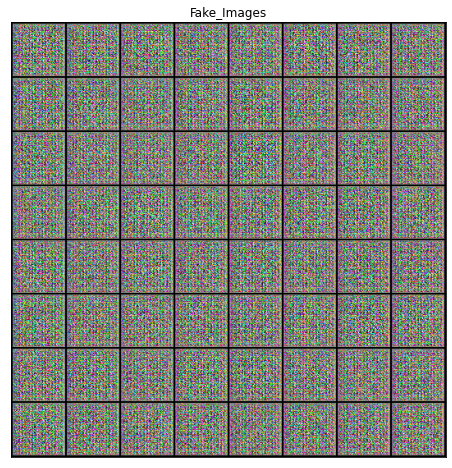

In [29]:
# Aufruf der Funktion
saves_gen_samples(0, random_Tensor)

In [30]:
"""
Zentrale Trainings-Funktion
"""

'\nZentrale Trainings-Funktion\n'

In [31]:
def train(NN_Discriminator, NN_Generator, NUM_EPOCH, LR, start_idx=1):
    t.cuda.empty_cache()  # leert den Cache, wenn auf der GPU gearbeitet wird

    NN_Discriminator.train()
    NN_Generator.train()

    # Listen für Übersicht des Fortschritts
    G_losses = []
    D_losses = []

    Gen_Opt = t.optim.RMSprop(NN_Generator.parameters(),
                              lr=LR)
    Dis_Opt = t.optim.RMSprop(NN_Discriminator.parameters(),
                              lr=LR)

    # Iteration über die Epochen
    for epoch in range(0, NUM_EPOCH):

        # Iteration über die Bilder
        for i, (img_real, _) in enumerate(org_loader):

            for _ in range(N_CRTIC):
                # Trainieren des Diskrimniators
                d_loss = disc_train(img_real, Dis_Opt)


                
                for p in NN_Discriminator.parameters():
                    p.data.clamp_(-WEIGHT_CLIPPING, WEIGHT_CLIPPING)

            # Trainieren des Generators
            g_loss = gen_train(Gen_Opt)

            Count = i  # Index/ Iterationen zählen
            print("index:", i, "D_loss:", d_loss, "G_Loss:", g_loss)

        # Speichern des Gesamtlosses von Critic/ Diskriminator und Generator
        D_losses.append(d_loss)
        G_losses.append(g_loss)


        # Ausgabe EPOCH, Loss: Gen und Critic/ Disc 
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}".format(
            epoch+1, NUM_EPOCH, g_loss, d_loss)) 

        # Speichern der generierten Samples/ Images
        saves_gen_samples(epoch+start_idx, random_Tensor)

    return G_losses, D_losses

In [32]:
# Aufruf der Trainingsfunktion (Diskriminator/Critic & Generator mit der LR & Anzahl der Epochen)
G_losses, D_losses = train(NN_Discriminator, NN_Generator, NUM_EPOCH, LR)

index: 0 D_loss: -0.06891371309757233 G_Loss: 0.01956689916551113
index: 1 D_loss: -0.05206936597824097 G_Loss: -0.00796483550220728
index: 2 D_loss: -0.05109727755188942 G_Loss: -0.021853923797607422


<h2> Grafische Darstellung des Loss von Generator und Critic/ Discriminators

In [ ]:
# Darstellung Loss 
EPOCH_COUNT_G= range(1,len(G_losses)+1) # Anzahl der Epochen vom Gen.
EPOCH_COUNT_D= range(1,len(D_losses)+1) # Anzahl der Epochen vom Dis.

plt.figure(figsize=(10,5))
plt.title("LOSS: Generator und Discriminator während dem Training")
plt.plot(EPOCH_COUNT_G, G_losses,"r-", label="Gen")
plt. plot(EPOCH_COUNT_D,D_losses,"b-", label="Dis")
plt.xlabel("EPOCH")
plt.ylabel("LOSS")
plt.legend()
plt.show()